In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from torch.utils.data import DataLoader
from physics import CS
from transformation import Shift
import unet
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from torch.utils.data import DataLoader

import os
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
dtype = torch.float
device = 'cuda:0'
batch_size = 1

# test set
test_dataset = USPS(root='./dataset/', train=False, download=True, transform=transforms.ToTensor())
test_dataloader=DataLoader(test_dataset,batch_size=1,shuffle=False)

# define a CS (4x) operator
physics = CS.CS(64, 256, [1,16,16], dtype, device)
# ground-truh
x = test_dataset[0][0].type(dtype).to(device) #torch.Size([1, 1, 16, 16])
# measurement
y = physics.A(x)

In [3]:
dtype = torch.float
device = 'cuda:0'
batch_size = 1
G = unet.UNet().to(device)
f = lambda y: G(physics.A_dagger(y))
T = Shift.Shift(n_trans=2) 

# CS Operator
physics = CS.CS(64, 256, [1,16,16], dtype, device)

x (GT): torch.Size([1, 16, 16])	y: torch.Size([1, 64])


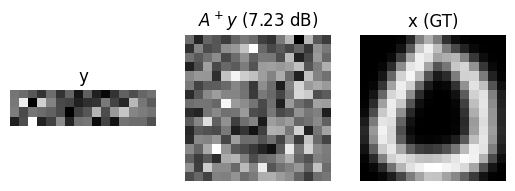

In [4]:
dtype = torch.float
device = 'cuda:0'
batch_size = 1

# test set
test_dataset = USPS(root='./dataset/', train=False, download=True, transform=transforms.ToTensor())
test_dataloader=DataLoader(test_dataset,batch_size=1,shuffle=False)

# ground-truh
x = test_dataset[5][0].type(dtype).to(device) #torch.Size([1, 1, 16, 16])

# measurement
y = physics.A(x)

print(f'x (GT): {x.shape}\ty: {y.shape}')

def torch2img(x):
  return x.squeeze().detach().cpu().numpy()
  
def cal_psnr(a, b):
  alpha = np.sqrt(a.shape[-1]*a.shape[-2])
  psnr = 20*torch.log10(alpha*torch.norm(b, float('inf'))/torch.norm(b-a, 2))
  return psnr.detach().cpu().numpy()

ATy = physics.A_dagger(y)
# have a look at the cs measurement y, A^+y, and the ground-truth x.
plt.subplot(1,3,1)
plt.imshow(torch2img(y.view(1,1,4,16)), cmap='gray'), plt.title('y'), plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(torch2img(ATy), cmap='gray'), plt.title(r'$A^+y$ ({:.2f} dB)'.format(cal_psnr(ATy, x))), plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(torch2img(x), cmap='gray'), plt.title('x (GT)'), plt.axis('off')
plt.show()

## Train the model  :

In [6]:
# Equivariant Imaging
# note: the below hyper-parameters value is just for an example and may not be the best setting.
lr = 5e-4
wd = 1e-8
batch_size=8
epochs = 30
ckp_interval = 100
alpha = 10 # equivariance strength


dataloader=DataLoader(USPS(root='./dataset/',train=True,download=True, transform=transforms.ToTensor()),batch_size=batch_size,shuffle=True)
now = lambda: datetime.now().strftime('%y-%m-%d-%H:%M:%S')

def train(alpha=alpha):
  optimizer = torch.optim.Adam(G.parameters(), lr=lr, weight_decay=wd)
  mse = torch.nn.MSELoss().to(device)

  save_path = './ckp/ei_cs4x_alpha_{}'.format( alpha)
 
  os.makedirs(save_path, exist_ok=True)

  loss_mc_epoch, loss_ei_epoch, loss_epoch, psnr_epoch = [], [], [], []

  for epoch in range(epochs):
    
    for i, x in enumerate(dataloader):
      x = x[0].type(dtype).to(device) #torch.Size([4, 1, 16, 16])
      y = physics.A(x) #generate the measurements for training
      
      # only 4 lines of code for training EI
      # =========== EI start ============
      x1 = f(y) # reconstruction of the groundtruth x
      x2 = T.apply(x1) # transform
      x3 = f(physics.A(x2)) # reconstruct the transformed data
      loss = mse(physics.A(x1), y) + alpha * mse(x3, x2)

      loss_mc_epoch.append(mse(physics.A(x1), y))
      loss_ei_epoch.append( mse(x3, x2))
      
      
      # =========== EI end ============

      loss_epoch.append(loss.item())
      psnr_epoch.append(cal_psnr(x1, x)) # 

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print('{}\t[{}/{}]\tloss={:.4e}\tpsnr={:.3f}'.format(now(), epoch+1,epochs,np.mean(loss_epoch), np.mean(psnr_epoch)))
    
    # save the trained model
    if epoch % ckp_interval == 0 or epoch + 1 == epochs:
      state = {'epoch': epoch, 'state_dict': G.state_dict(), 'optimizer': optimizer.state_dict()} 
      torch.save(state, os.path.join(save_path, 'ckp_{}.pth.tar'.format(epoch)))


  return loss_mc_epoch, loss_ei_epoch, loss_epoch, psnr_epoch 



loss_mc_epoch, loss_ei_epoch, loss_epoch, psnr_epoch  = train()

24-02-08-11:47:35	[1/30]	loss=1.1246e-01	psnr=5.652
24-02-08-11:47:49	[2/30]	loss=8.1458e-02	psnr=6.903
24-02-08-11:48:04	[3/30]	loss=6.7475e-02	psnr=7.638
24-02-08-11:48:20	[4/30]	loss=5.9026e-02	psnr=8.142
24-02-08-11:48:34	[5/30]	loss=5.3447e-02	psnr=8.516
24-02-08-11:48:49	[6/30]	loss=4.9371e-02	psnr=8.815
24-02-08-11:49:04	[7/30]	loss=4.6255e-02	psnr=9.075
24-02-08-11:49:18	[8/30]	loss=4.3781e-02	psnr=9.300
24-02-08-11:49:32	[9/30]	loss=4.1653e-02	psnr=9.505
24-02-08-11:49:46	[10/30]	loss=3.9849e-02	psnr=9.685
24-02-08-11:50:00	[11/30]	loss=3.8295e-02	psnr=9.844
24-02-08-11:50:14	[12/30]	loss=3.6876e-02	psnr=9.993
24-02-08-11:50:28	[13/30]	loss=3.5637e-02	psnr=10.128
24-02-08-11:50:41	[14/30]	loss=3.4508e-02	psnr=10.249
24-02-08-11:50:56	[15/30]	loss=3.3484e-02	psnr=10.360
24-02-08-11:51:10	[16/30]	loss=3.2550e-02	psnr=10.463
24-02-08-11:51:24	[17/30]	loss=3.1681e-02	psnr=10.560
24-02-08-11:51:38	[18/30]	loss=3.0917e-02	psnr=10.646
24-02-08-11:51:52	[19/30]	loss=3.0189e-02	psnr=10

### Saving results

In [5]:
d = {"loss_mc_epoch" : loss_mc_epoch , "loss_ei_epoch" : loss_ei_epoch, "loss_epoch" : loss_epoch , "psnr_epoch" : psnr_epoch}

import pickle


with open('results/filename.pickle', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'loss_mc_epoch' is not defined

### Import result

In [5]:
import pickle

In [11]:
with open('results/filename.pickle', 'rb') as handle:
    results_dict = pickle.load(handle)

In [24]:
loss_mc_epoch = results_dict['loss_mc_epoch']
loss_ei_epoch = results_dict['loss_ei_epoch']
loss_epoch = results_dict['loss_epoch']
psnr_epoch = results_dict['psnr_epoch']
len(psnr_epoch)/30

912.0

In [28]:
loss_mc_epoch = results_dict['loss_mc_epoch']
loss_ei_epoch = results_dict['loss_ei_epoch']
loss_epoch = results_dict['loss_epoch']
psnr_epoch = results_dict['psnr_epoch']
loss_mc_epoch1 = [float(loss_mc_epoch[i].to('cpu')) for i in range(len(loss_mc_epoch)) if i%912 == 0]
loss_ei_epoch1 = [float(loss_ei_epoch[i].to('cpu')) for i in range(len(loss_ei_epoch)) if i%912 == 0]
psnr_epoch1 = [float(psnr_epoch[i]) for i in range(len(psnr_epoch)) if i%911 == 0]
psnr_epoch1 = [psnr_epoch[k] for k in range(len(psnr_epoch)) if k%911 ==0]

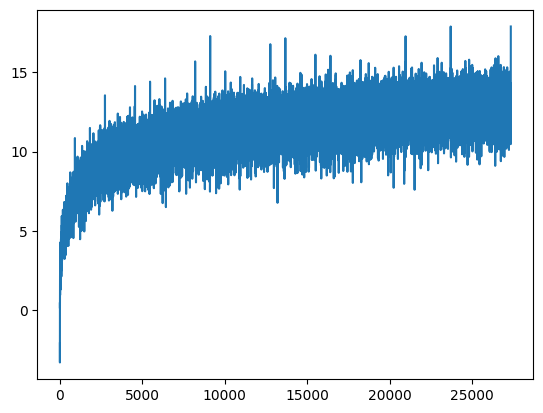

In [32]:

plt.plot(psnr_epoch)

## Model Evaluation

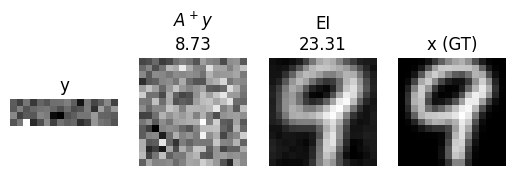

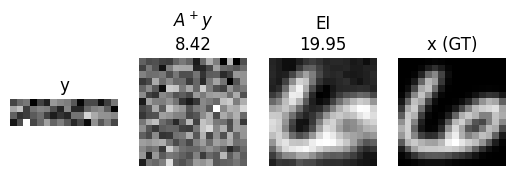

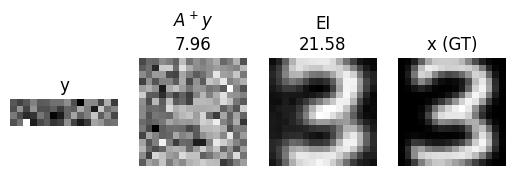

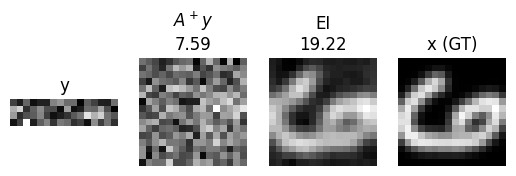

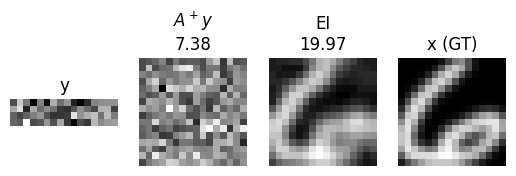

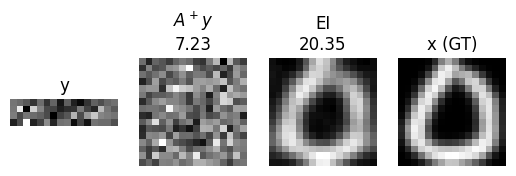

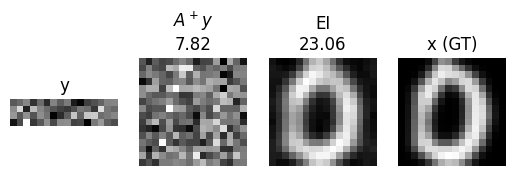

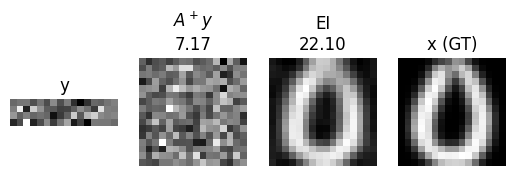

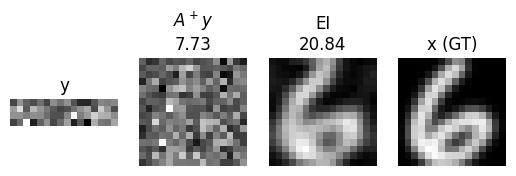

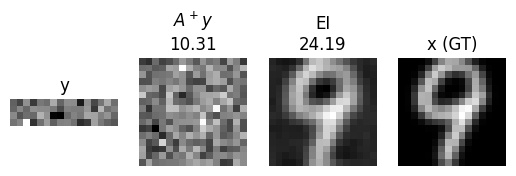

In [16]:
# Test
def test(net, ckp, ATy):
  checkpoint = torch.load(ckp, map_location=device)
  net.load_state_dict(checkpoint['state_dict'])
  net.to(device).eval()
  return net(ATy)

# load the trained EI model
ckp_ei = 'ckp\ei_cs4x_alpha_10\ckp_29.pth.tar'
unet_model = unet.UNet().to(device)

for i in range(10):

  # ground-truh
  x = test_dataset[i][0].type(dtype).to(device) #torch.Size([1, 1, 16, 16])
  # measurement
  y = physics.A(x)
  ATy = physics.A_dagger(y)
  x_ei = test(unet_model, ckp_ei, ATy)
  plt.figure(i)
  plt.subplot(1,4,1)
  plt.imshow(torch2img(y.view(1,1,4,16)), cmap='gray'), plt.title('y'), plt.axis('off')
  plt.subplot(1,4,2)
  plt.imshow(torch2img(ATy), cmap='gray'), plt.title(r'$A^+y$'+'\n{:.2f}'.format(cal_psnr(ATy, x))), plt.axis('off')
  plt.subplot(1,4,3)
  plt.imshow(torch2img(x_ei), cmap='gray'), plt.title('EI\n{:.2f}'.format(cal_psnr(x_ei, x))), plt.axis('off')
  plt.subplot(1,4,4)
  plt.imshow(torch2img(x), cmap='gray'), plt.title('x (GT)'), plt.axis('off')
  plt.show()